## Skin Cancer Classification | Transfer Learning | XAI

#### Load image dataset


This python files set the path for the folders where train and test images are stored, inspect the data (i.e. number of images), create dataframe using path to each image and theor labels.

In [1]:
pip install scikit-plot tensorflow-hub tensorflow_addons -q vit-keras tf-keras-vis lime

In [2]:
# Import required packages
import os
import glob
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from vit_keras import vit
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, Multiply, GlobalAveragePooling2D, Reshape, MaxPool2D

from lime import lime_image
from skimage.segmentation import mark_boundaries
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# In case running with Google colab mount the drive to access the dataset uploaded on drive (If running in local no need to run this step)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define the path to dataset - data is stored in folder named data/train and data/test
# In case running on local system, you can define path to the folder where data is stored
path_train = '/content/drive/MyDrive/Colab Notebooks/8013/data/train/'
path_test = '/content/drive/MyDrive/Colab Notebooks/8013/data/test/'

In [5]:
# Use glob to get path for images withtin folders
train_images = glob.glob(f"{path_train}**/*.jpg")
test_images = glob.glob(f"{path_test}**/*.jpg")

In [6]:
# Check the size of training and testing data(images)
train_samples = len(train_images)
test_samples = len(test_images)

print(f'train samples count: {train_samples}')
print(f'test samples count: {test_samples}')

train samples count: 2637
test samples count: 660


In [7]:
# Create dataframe to store path to each image along with label

# generate labels
trian_labels = [_.split('/')[-2:][0] for _ in train_images]
test_labels = [_.split('/')[-2:][0] for _ in test_images]


train_df = pd.DataFrame({
    'image_path': train_images,
    'label': trian_labels
})

test_df = pd.DataFrame({
    'image_path': test_images,
    'label': test_labels
})

# Generate encoded labels malignant - 1, benign - 0
train_df['label_encoded'] = train_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)
test_df['label_encoded'] = test_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)

### EDA

Thia code is used for some basic EDA on training and testing data
 - check class balance in both training and testing data
 - view sample training images of both classes

In [8]:
#class balance check train & test
train_class_count = train_df['label'].value_counts()
test_class_count = test_df['label'].value_counts()

print(f"train_class_count: {train_class_count}")
print(f"test_class_count: {test_class_count}")

train_class_count: label
benign       1440
malignant    1197
Name: count, dtype: int64
test_class_count: label
benign       360
malignant    300
Name: count, dtype: int64


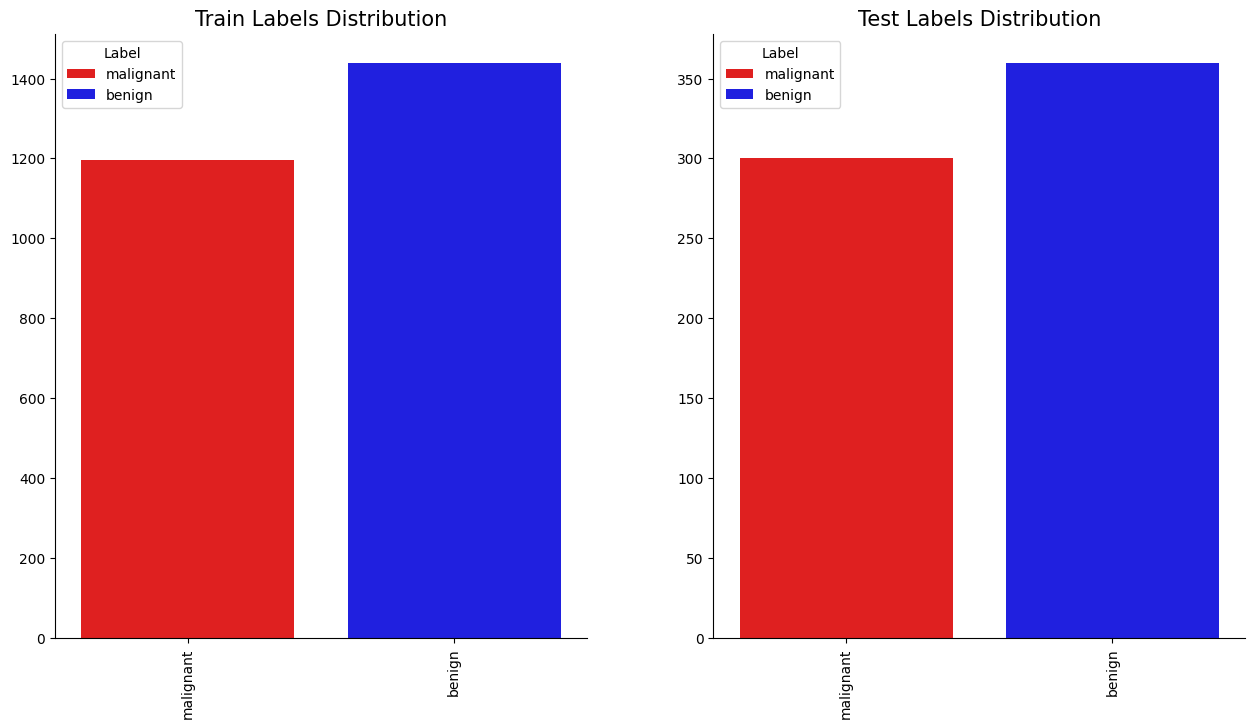

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))  # Changed to 1 row and 2 columns

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Create a dictionary to map categories to colors
color_mapping = {'malignant': 'red', 'benign': 'blue'}

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=15)

# Plot each category with its specific color
for category, color in color_mapping.items():
    # Filter the data for the category
    cat_data = train_class_count.get(category, 0)
    sns.barplot(x=[category], y=[cat_data], color=color, ax=ax1, label=category)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=15)

# Plot each category with its specific color
for category, color in color_mapping.items():
    # Filter the data for the category
    cat_data = test_class_count.get(category, 0)
    sns.barplot(x=[category], y=[cat_data], color=color, ax=ax2, label=category)

# To prevent the labels from overlapping with the plots
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

# Add legend
ax1.legend(title="Label")
ax2.legend(title="Label")

sns.despine()

plt.show()

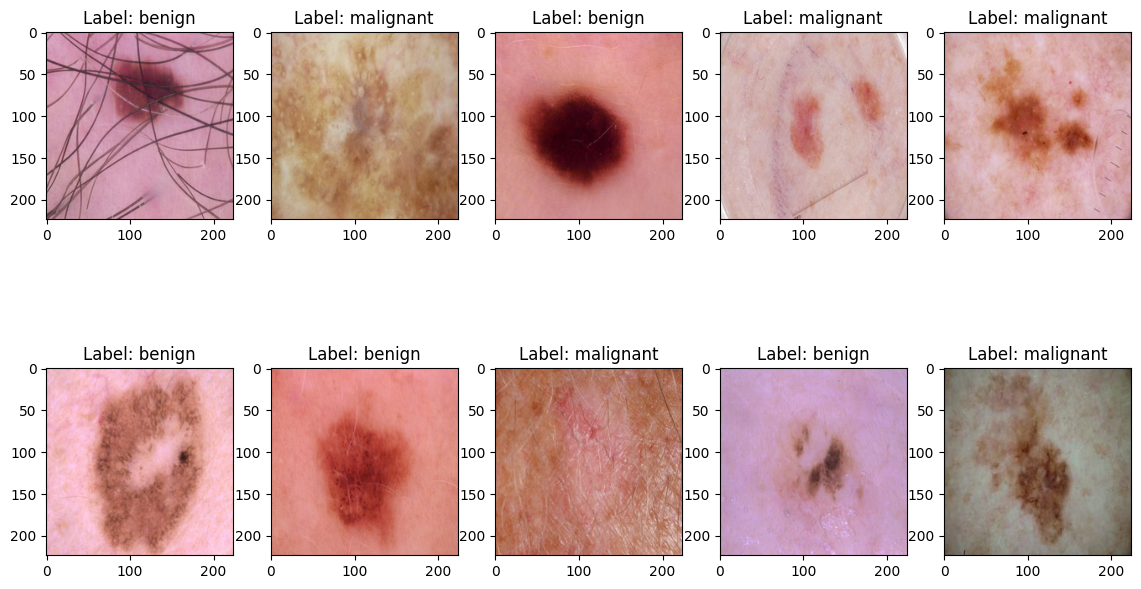

In [10]:
# View sample training images from both the classes
def load_image(image_path):

    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [224, 224],
                            method = tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

idx = random.sample(train_df.index.to_list(), 10)
fig = plt.figure(figsize=(14,8))

for id, _ in enumerate(idx):

    plt.subplot(2, 5, id+1)
    plt.title(f'Label: {train_df.label[_]}')
    plt.imshow(load_image(train_df.image_path[_]))

### Pre-processing data

This code performes few pre-processing steps on training & testing data like:
- split training into train-validation split
- add custom augmengtation layer(can be replaced with ImageDataGenerator) - here data is preety much balanced already so no need to do higher augmentation, only randomflip & randomzoom is performed.
- prepare tensor dataset and batches using tensorfloe.data.Dataset to fit in the training data


In [11]:
# Split the training data into train-validation set
train_idx, val_ind, _, _ = train_test_split(train_df.index, train_df.label_encoded, test_size = 0.20,
                                            stratify = train_df.label_encoded, random_state = 42)

# Get training and validation data
train_new_df = train_df.iloc[train_idx].reset_index(drop=True)
val_df = train_df.iloc[val_ind].reset_index(drop=True)

# View shapes
print(f"training size: {train_new_df.shape}, validation size: {val_df.shape}")

training size: (2109, 3), validation size: (528, 3)


In [12]:
# Check class balance in both trainng and validation set
train_class_count = train_new_df['label'].value_counts()
val_class_count = val_df['label'].value_counts()

print(f"train_class_count: {train_class_count}")
print(f"test_class_count: {val_class_count}")

train_class_count: label
benign       1152
malignant     957
Name: count, dtype: int64
test_class_count: label
benign       288
malignant    240
Name: count, dtype: int64


In [13]:
# Build custome augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed = 42),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed = 42),
], name='augmentation_layer')

In [14]:
# Define function to build tensor batched dataset
def pre_processing(orig_df, augmentation = False):

    # Get image paths and labels from DataFrame
    image_paths = orig_df.image_path
    image_labels = tf.one_hot(orig_df.label_encoded, depth = 2).numpy()

    # create tensor dataset from original data
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # apply augmentation layer to the data
    if augmentation:
          dataset = dataset.map(lambda x, y: (augmentation_layer(load_image(x)), y), num_parallel_calls = tf.data.AUTOTUNE)
    else:
          dataset = dataset.map(lambda x, y: (load_image(x), y), num_parallel_calls = tf.data.AUTOTUNE)

    # apply batching
    dataset = dataset.batch(32)

    return dataset

In [15]:
# Generate tensor datasets for train, validation(no augmentation) and test(no augmentation)
train_dataset = pre_processing(train_new_df, augmentation = True)

val_dataset = pre_processing(val_df)

test_dataset = pre_processing(test_df)

In [16]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

### EfficientNet

This code builds and train Transfer Learning-enhanced version of EfficientNet model from TensorFlow Hub, check validation and test accuracy and other performance parameters

In [17]:
# Load the base EfficientNetB0 model
efficientnet = EfficientNetB0(include_top=True, weights=None, classes = 2)

In [18]:
# Define Efficient V2 model
def efficientnet_sequential():

    inputs = layers.Input(shape = (224, 224, 3), dtype = tf.float32, name = 'input_image')

    outputs = EfficientNetB0(include_top=True, weights=None, classes=2)(inputs)

    efficientnet_sequential = tf.keras.Model(inputs, outputs)

    tf.random.set_seed(42)

    # Compile the model
    efficientnet_sequential.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                  metrics = "accuracy")

    return efficientnet_sequential

In [19]:
# initialize model
efficientnet_model = efficientnet_sequential()

print(efficientnet_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 2)                 4052133   
 )                                                               
                                                                 
Total params: 4052133 (15.46 MB)
Trainable params: 4010110 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________
None


In [20]:
# train model with training data
efficientnet_training = efficientnet_model.fit(train_dataset, epochs = 50, validation_data = val_dataset, validation_steps = int(len(val_dataset)),
                                            callbacks = early_stopping)

Epoch 1/50
66/66 [==============================] - 754s 10s/step - loss: 1.3190 - accuracy: 0.7231 - val_loss: 1.0238 - val_accuracy: 0.5455
Epoch 2/50
66/66 [==============================] - 690s 10s/step - loss: 0.7290 - accuracy: 0.7757 - val_loss: 0.9896 - val_accuracy: 0.5455
Epoch 3/50
66/66 [==============================] - 687s 10s/step - loss: 0.7611 - accuracy: 0.7809 - val_loss: 1.1036 - val_accuracy: 0.5455
Epoch 4/50
66/66 [==============================] - 688s 10s/step - loss: 0.6023 - accuracy: 0.7809 - val_loss: 1.2650 - val_accuracy: 0.5455
Epoch 5/50
66/66 [==============================] - 676s 10s/step - loss: 0.6582 - accuracy: 0.7819 - val_loss: 1.6506 - val_accuracy: 0.5455


In [21]:
# Evaluate the model on test dataframe
efficientnet_evaluation = efficientnet_model.evaluate(test_dataset)

21/21 [==============================] - 164s 8s/step - loss: 0.9896 - accuracy: 0.5455


In [22]:
# Generate model probabilities and associated predictions
efficientnet_test_prob = efficientnet_model.predict(test_dataset, verbose=1)
efficientnet_test_pred = tf.argmax(efficientnet_test_prob, axis=1)

21/21 [==============================] - 79s 2s/step


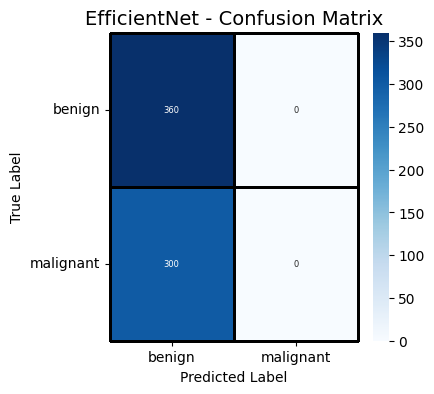

In [23]:
# generate & plot confusion matrics to check False positives & False negatuves
efficientnet_confusion_matrix = confusion_matrix(test_df.label_encoded, efficientnet_test_pred)

# Set plot size
plt1 = plt.figure(figsize = (4, 4))

# Create confusion matrix heatmap
disp = sns.heatmap(efficientnet_confusion_matrix, annot = True, cmap = 'Blues',
                   annot_kws={"size": 6}, fmt='g',
                   linewidths=1, linecolor='black', clip_on=False,
                   xticklabels = ['benign', 'malignant'], yticklabels = ['benign', 'malignant'])

# Set title and axis labels
disp.set_title('EfficientNet - Confusion Matrix', fontsize = 14)
disp.set_xlabel('Predicted Label', fontsize = 10)
disp.set_ylabel('True Label', fontsize = 10)
plt.yticks(rotation=0)

# Plot confusion matrix
plt1.savefig("/content/drive/MyDrive/Colab Notebooks/8013/EfficientNet_CM.pdf")
plt1.show()

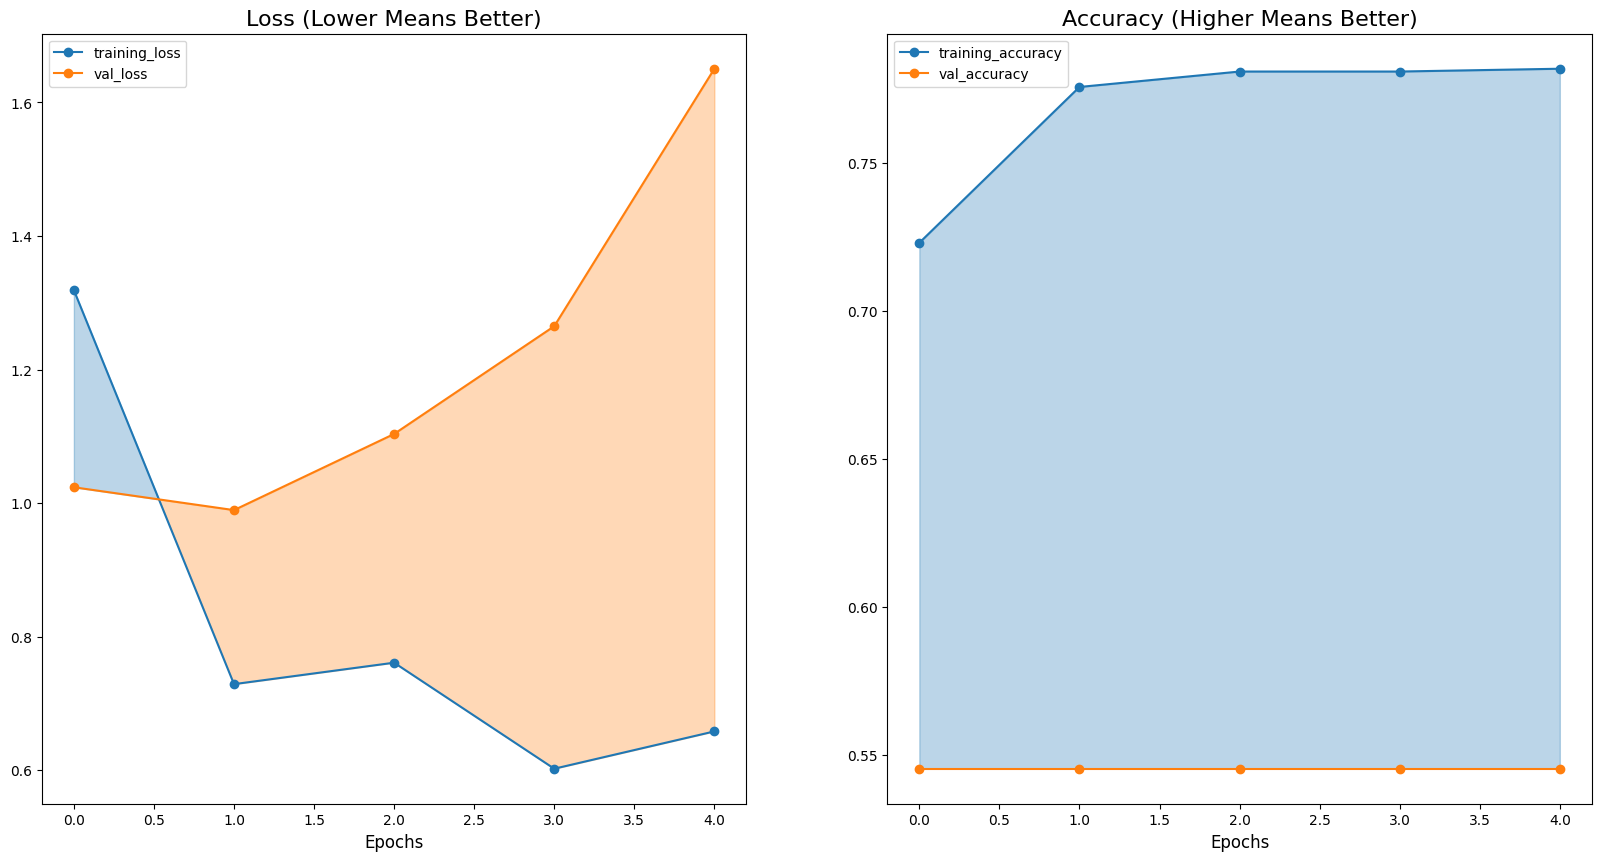

In [24]:
# Ploting train - validation Accuracy and loss curves and ROC curve
train_loss = np.array(efficientnet_training.history['loss'])
val_loss = np.array(efficientnet_training.history['val_loss'])

train_accuracy = np.array(efficientnet_training.history['accuracy'])
val_accuracy = np.array(efficientnet_training.history['val_accuracy'])

epochs = range(len(efficientnet_training.history['loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot loss
ax1.plot(epochs, train_loss, label='training_loss', marker='o')
ax1.plot(epochs, val_loss, label='val_loss', marker='o')

ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss > val_loss), color='C0', alpha=0.3, interpolate=True)
ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss < val_loss), color='C1', alpha=0.3, interpolate=True)

ax1.set_title('Loss (Lower Means Better)', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend()

# Plot accuracy
ax2.plot(epochs, train_accuracy, label='training_accuracy', marker='o')
ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.legend();

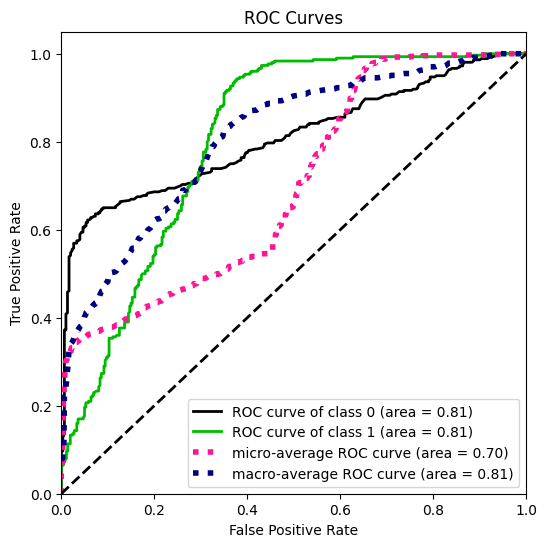

In [25]:
# plot roc curve
plt2 = plot_roc(test_df.label_encoded, efficientnet_test_prob, figsize=(6, 6), title_fontsize='large')
plt2.figure.savefig("/content/drive/MyDrive/Colab Notebooks/8013/EfficientNet_ROC.pdf")

In [26]:
# CNN classification report
print(classification_report(test_df.label_encoded,
                            efficientnet_test_pred,
                            target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.55      1.00      0.71       360
   Malignant       0.00      0.00      0.00       300

    accuracy                           0.55       660
   macro avg       0.27      0.50      0.35       660
weighted avg       0.30      0.55      0.39       660



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# # Load the EfficientNetV2-B0 model
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2"
efficientnet_v2_b0 = hub.KerasLayer(model_url, trainable = False, name = 'efficientnet_v2_b0')

In [28]:
# Define Efficient V2 model
def efficientnet_v2():

    efficientnet_v2_sequential = Sequential([
        layers.Input(shape = (224, 224, 3), dtype = tf.float32, name = 'input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid')
        ], name='efficientnet_v2_sequential_model')

    tf.random.set_seed(42)

    # Compile the model
    efficientnet_v2_sequential.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                  metrics = "accuracy")

    return efficientnet_v2_sequential

In [29]:
# initialize model
efficientnet_v2_model = efficientnet_v2()

print(efficientnet_v2_model.summary())

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6083538 (23.21 MB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________
None


In [30]:
# train model with training data
efficientnet_v2_training = efficientnet_v2_model.fit(train_dataset, epochs = 50, validation_data = val_dataset, validation_steps = int(len(val_dataset)),
                                            callbacks = early_stopping)

Epoch 1/50
66/66 [==============================] - 182s 3s/step - loss: 1.9595 - accuracy: 0.7843 - val_loss: 1.1717 - val_accuracy: 0.8561
Epoch 2/50
66/66 [==============================] - 170s 3s/step - loss: 0.9345 - accuracy: 0.8677 - val_loss: 0.7525 - val_accuracy: 0.8636
Epoch 3/50
66/66 [==============================] - 170s 3s/step - loss: 0.6555 - accuracy: 0.8781 - val_loss: 0.5826 - val_accuracy: 0.8731
Epoch 4/50
66/66 [==============================] - 169s 3s/step - loss: 0.5461 - accuracy: 0.8644 - val_loss: 0.4982 - val_accuracy: 0.8693
Epoch 5/50
66/66 [==============================] - 157s 2s/step - loss: 0.4762 - accuracy: 0.8720 - val_loss: 0.4530 - val_accuracy: 0.8655
Epoch 6/50
66/66 [==============================] - 170s 3s/step - loss: 0.4334 - accuracy: 0.8748 - val_loss: 0.4421 - val_accuracy: 0.8561
Epoch 7/50
66/66 [==============================] - 172s 3s/step - loss: 0.3968 - accuracy: 0.8810 - val_loss: 0.4266 - val_accuracy: 0.8655
Epoch 8/50
66

In [31]:
# Evaluate the model on test dataframe
efficientnet_v2_evaluation = efficientnet_v2_model.evaluate(test_dataset)

21/21 [==============================] - 37s 2s/step - loss: 0.3646 - accuracy: 0.8636


In [32]:
# Generate model probabilities and associated predictions
efficientnet_v2_test_prob = efficientnet_v2_model.predict(test_dataset, verbose=1)
efficientnet_v2_test_pred = tf.argmax(efficientnet_v2_test_prob, axis=1)

21/21 [==============================] - 93s 2s/step


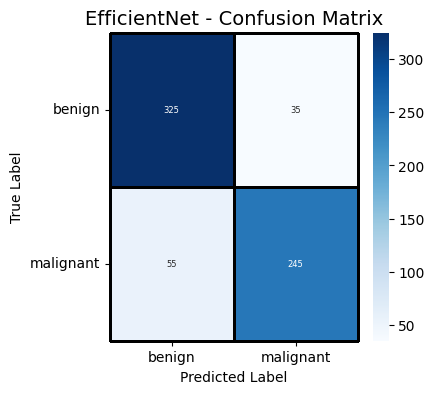

In [33]:
# generate & plot confusion matrics to check False positives & False negatuves
efficientnet_confusion_matrix = confusion_matrix(test_df.label_encoded, efficientnet_v2_test_pred)

# Set plot size
plt3 = plt.figure(figsize = (4, 4))

# Create confusion matrix heatmap
disp = sns.heatmap(efficientnet_confusion_matrix, annot = True, cmap = 'Blues',
                   annot_kws={"size": 6}, fmt='g',
                   linewidths=1, linecolor='black', clip_on=False,
                   xticklabels = ['benign', 'malignant'], yticklabels = ['benign', 'malignant'])

# Set title and axis labels
disp.set_title('EfficientNet - Confusion Matrix', fontsize = 14)
disp.set_xlabel('Predicted Label', fontsize = 10)
disp.set_ylabel('True Label', fontsize = 10)
plt.yticks(rotation=0)

# Plot confusion matrix
plt3.savefig("/content/drive/MyDrive/Colab Notebooks/8013/EfficientNet_v2_CM.pdf")
plt3.show()

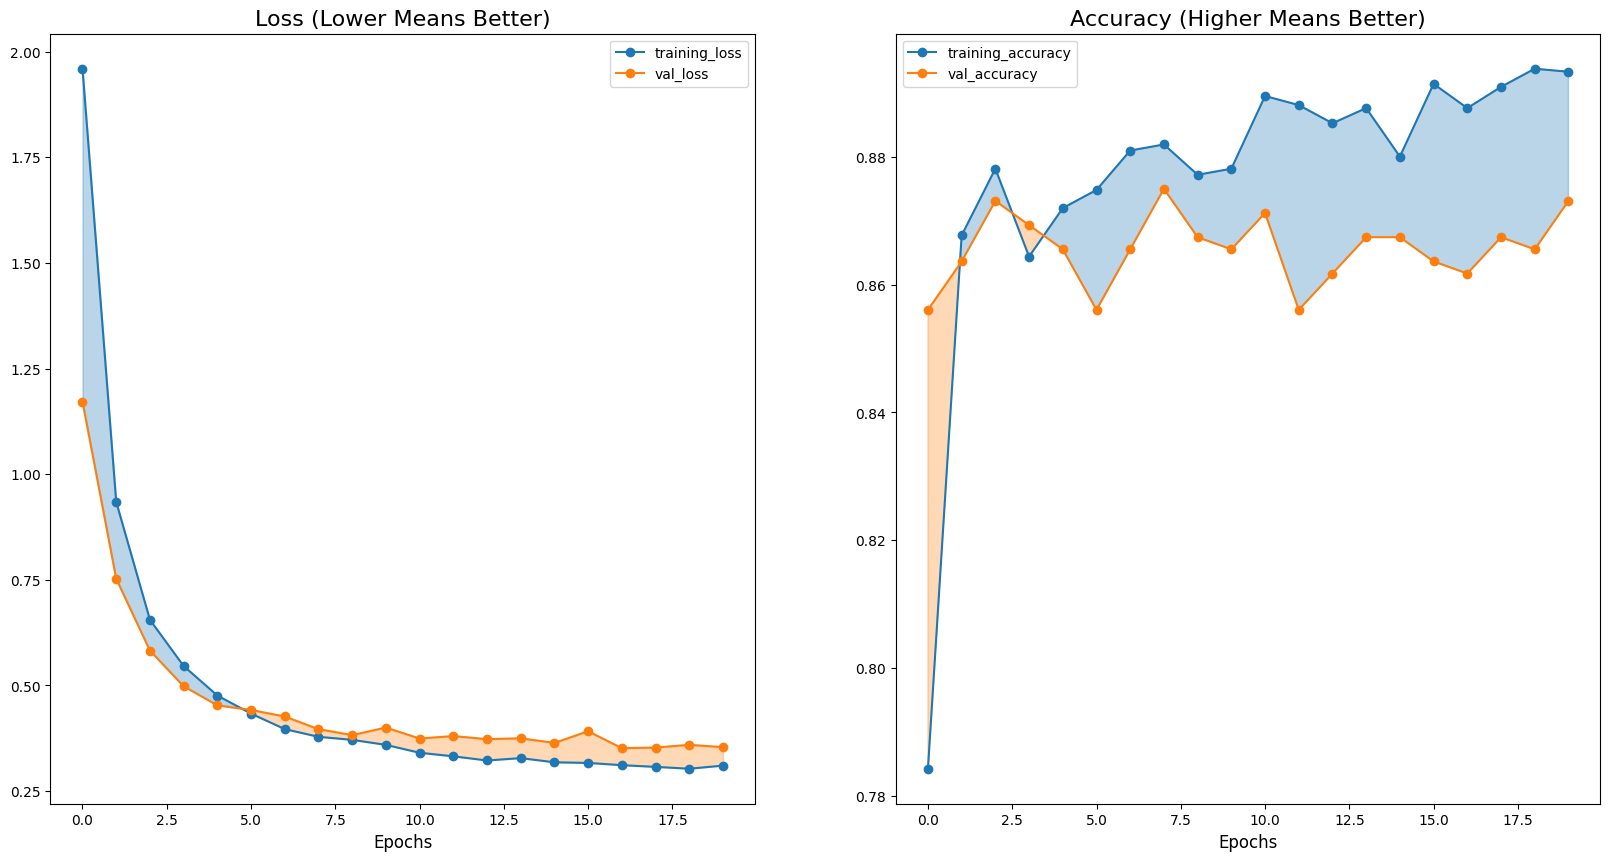

In [34]:
# Ploting train - validation Accuracy and loss curves and ROC curve
train_loss = np.array(efficientnet_v2_training.history['loss'])
val_loss = np.array(efficientnet_v2_training.history['val_loss'])

train_accuracy = np.array(efficientnet_v2_training.history['accuracy'])
val_accuracy = np.array(efficientnet_v2_training.history['val_accuracy'])

epochs = range(len(efficientnet_v2_training.history['loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot loss
ax1.plot(epochs, train_loss, label='training_loss', marker='o')
ax1.plot(epochs, val_loss, label='val_loss', marker='o')

ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss > val_loss), color='C0', alpha=0.3, interpolate=True)
ax1.fill_between(epochs, train_loss, val_loss, where=(train_loss < val_loss), color='C1', alpha=0.3, interpolate=True)

ax1.set_title('Loss (Lower Means Better)', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend()

# Plot accuracy
ax2.plot(epochs, train_accuracy, label='training_accuracy', marker='o')
ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
ax2.fill_between(epochs, train_accuracy, val_accuracy, where=(train_accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.legend();

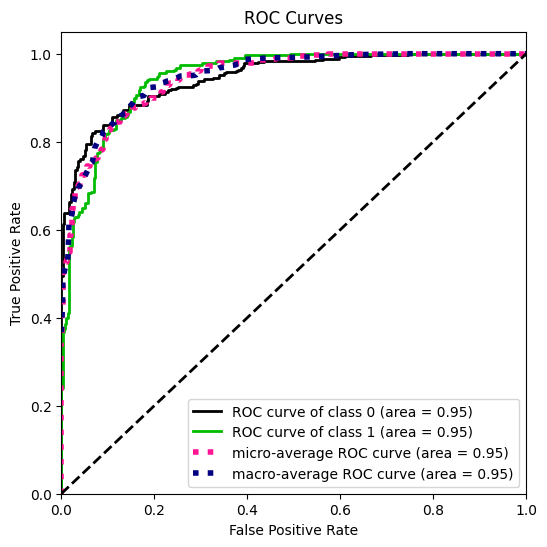

In [35]:
# plot roc curve
plt4 = plot_roc(test_df.label_encoded, efficientnet_v2_test_prob, figsize=(6, 6), title_fontsize='large')
plt4.figure.savefig("/content/drive/MyDrive/Colab Notebooks/8013/EfficientNet_v2_ROC.pdf")

In [36]:
# CNN classification report
print(classification_report(test_df.label_encoded,
                            efficientnet_v2_test_pred,
                            target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.86      0.90      0.88       360
   Malignant       0.88      0.82      0.84       300

    accuracy                           0.86       660
   macro avg       0.87      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660

